У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [134]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek
from openpyxl.styles.builtins import percent
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv('/Users/macbook/Desktop/machine_learning_course/customer_segmentation_train.csv')

In [69]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [71]:
df.isna().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [72]:
# statistics for numeric data
df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [73]:
# categorical variables
df.select_dtypes(include='object').columns

Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1', 'Segmentation'],
      dtype='object')

In [74]:
# numeric variables
df.select_dtypes(include='number')

,ID,Age,Work_Experience,Family_Size
0,462809,22,1.0,4.0
1,462643,38,NaN,3.0
2,466315,67,1.0,1.0
3,461735,67,0.0,2.0
4,462669,40,NaN,6.0
...,...,...,...,...
8063,464018,22,0.0,7.0
8064,464685,35,3.0,4.0
8065,465406,33,1.0,1.0
8066,467299,27,1.0,4.0


In [75]:
df.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [76]:
df.dtypes

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [77]:
# drop ID
df = df.drop('ID', axis=1)

In [78]:
y = df['Segmentation']
X = df.drop('Segmentation', axis=1)

In [79]:
# missing %
missing_percent = ((X.isna().sum()/len(X))*100).round(2)
missing_percent.sort_values(ascending=False)

Work_Experience    10.28
Family_Size         4.15
Ever_Married        1.74
Profession          1.54
Graduated           0.97
Var_1               0.94
Gender              0.00
Age                 0.00
Spending_Score      0.00
dtype: float64

Нічого не видаляємо, адже максимум пропущених значень лише приблизно 10%, можна проводити імпутацію.

<Axes: title={'center': 'Work_Experience Distribution'}, xlabel='Work_Experience'>

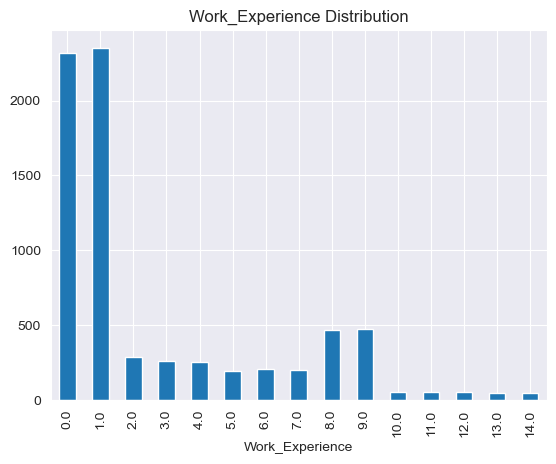

In [80]:
# work experience distribution
plt.title('Work_Experience Distribution')
X['Work_Experience'].value_counts().sort_index().plot(kind='bar')

In [81]:
X['Work_Experience'].median()

1.0

Можна заповнити медіаною пропущені значення для "Work_Experience".

In [82]:
X['Work_Experience'] = X['Work_Experience'].fillna(X['Work_Experience'].median())

<Axes: title={'center': 'Family Size Distribution'}, xlabel='Family_Size'>

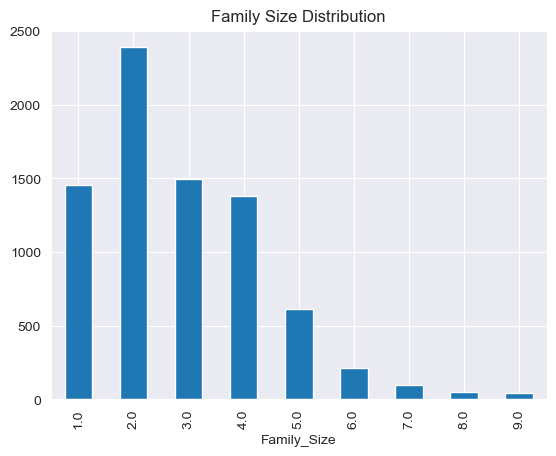

In [83]:
# family size distribution
plt.title('Family Size Distribution')
X['Family_Size'].value_counts().sort_index().plot(kind='bar')

In [84]:
X['Family_Size'].median()

3.0

In [85]:
X['Family_Size'].mode()

0    2.0
Name: Family_Size, dtype: float64

In [86]:
# median imputation
X['Family_Size'] = X['Family_Size'].fillna(X['Family_Size'].median())

In [87]:
X.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience      0
Spending_Score       0
Family_Size          0
Var_1               76
dtype: int64

In [88]:
X['Work_Experience'].head(10)

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
5    0.0
6    1.0
7    1.0
8    0.0
9    1.0
Name: Work_Experience, dtype: float64

In [89]:
# categorical columns mode imputation
cat_cols = ['Ever_Married', 'Graduated', 'Var_1']
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])




In [90]:
X.isna().sum()

Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession         124
Work_Experience      0
Spending_Score       0
Family_Size          0
Var_1                0
dtype: int64

In [92]:
X['Profession'] = X['Profession'].fillna('Unknown')

In [93]:
X.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [94]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [95]:
# OneHotEncoder for categorical
cat_cols = X_train.select_dtypes(include='object').columns
num_cols = X_train.select_dtypes(include='number').columns

In [107]:
# encoder
ohe = OneHotEncoder(handle_unknown='ignore')

X_train_cat = ohe.fit_transform(X_train[cat_cols]).toarray()
X_test_cat = ohe.transform(X_test[cat_cols]).toarray()

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

X_train_result = np.concatenate((X_train_num, X_train_cat), axis = 1)
X_test_result = np.concatenate((X_test_num, X_test_cat), axis = 1)


In [108]:
X_train_result.shape, X_test_result.shape

((6454, 29), (1614, 29))

In [117]:
# logistic regression (multiclass)
classifier = LogisticRegression(max_iter=2000)
classifier.fit(X_train_result, y_train)

LogisticRegression(max_iter=2000)

In [118]:
y_pred = classifier.predict(X_test_result)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.42      0.43      0.42       394
           B       0.40      0.24      0.30       372
           C       0.51      0.59      0.55       394
           D       0.65      0.75      0.70       454

    accuracy                           0.52      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.52      0.50      1614



Висновок: У базовій моделі Логістичної Регресії пробувала кілька варіантів ітерацій. У даному випадку 2000 ітерацій. Зі звіту видно, що загальна точність 0.52, непогано передбачає клас "Д" 0.75, найгірше передбачає клас В. Вцілому зі звіту видно нерівномірну якість передбачень між класами, тому переходимо до методів ресамплінгу.

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [103]:
!pip install -U imbalanced-learn

  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.3
    Uninstalling imbalanced-learn-0.12.3:
      Successfully uninstalled imbalanced-learn-0.12.3


In [127]:
# indices
cat_feature_indices = list(range(X_train_num.shape[1], X_train_result.shape[1]))

In [130]:
# SMOTENC
smotenc = SMOTENC(categorical_features=cat_feature_indices, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train_result, y_train)

smote_tomek = SMOTETomek(random_state=42, smote = SMOTENC(categorical_features=cat_feature_indices, random_state=42))
X_train_smotenc_tomek, y_train_smotenc_tomek = smote_tomek.fit_resample(X_train_result, y_train)

In [133]:
print("Original train:", X_train_result.shape, y_train.shape)
print("SMOTENC train - upsampling:", X_train_smotenc.shape, y_train_smotenc.shape)
print("SMOTENC-Tomek train - resampling:", X_train_smotenc_tomek.shape, y_train_smotenc_tomek.shape)

Original train: (6454, 29) (6454,)
SMOTENC train - upsampling: (7256, 29) (7256,)
SMOTENC-Tomek train - resampling: (5780, 29) (5780,)


In [132]:
print("Original y_train:")
print(y_train.value_counts())
print("SMOTENC y_train:")
print(y_train_smotenc.value_counts())
print("SMOTENC-Tomek y_train:")
print(y_train_smotenc_tomek.value_counts())

Original y_train:
Segmentation
D    1814
A    1578
C    1576
B    1486
Name: count, dtype: int64
SMOTENC y_train:
Segmentation
A    1814
B    1814
C    1814
D    1814
Name: count, dtype: int64
SMOTENC-Tomek y_train:
Segmentation
D    1480
C    1478
B    1423
A    1399
Name: count, dtype: int64


**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [135]:
# log reg OvR
log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)
ovr_model.fit(X_train_result, y_train)
ovr_pred = ovr_model.predict(X_test_result)
print(classification_report(y_test, ovr_pred))

              precision    recall  f1-score   support

           A       0.43      0.46      0.44       394
           B       0.42      0.17      0.25       372
           C       0.49      0.62      0.54       394
           D       0.65      0.76      0.70       454

    accuracy                           0.52      1614
   macro avg       0.50      0.50      0.48      1614
weighted avg       0.50      0.52      0.49      1614



In [138]:
# log reg OvR + SMOTENC
ovr_smotenc = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
ovr_smotenc.fit(X_train_smotenc, y_train_smotenc)
y_pred_smote = ovr_smotenc.predict(X_test_result)
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           A       0.42      0.46      0.44       394
           B       0.40      0.24      0.30       372
           C       0.50      0.59      0.54       394
           D       0.67      0.73      0.70       454

    accuracy                           0.52      1614
   macro avg       0.50      0.51      0.50      1614
weighted avg       0.51      0.52      0.51      1614



In [137]:
# log reg OvR + SMOTE-Tomek
ovr_tomek = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
ovr_tomek.fit(X_train_smotenc_tomek, y_train_smotenc_tomek)
y_pred_tomek = ovr_tomek.predict(X_test_result)
print(classification_report(y_test, y_pred_tomek))

              precision    recall  f1-score   support

           A       0.42      0.47      0.44       394
           B       0.40      0.24      0.30       372
           C       0.50      0.59      0.54       394
           D       0.67      0.71      0.69       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



Висновок: звіти показали, що результати трьох моделей схожі. Застосування ресемплінгу не призвело до суттєвого покращення метрик (я порівнюю метрики macro F1-score - баланс між класами та Accuracy - загальна картина, щоб порівняти чи модель не погіршилась). Трохи кращою виявілась друга модель (log reg OvR + SMOTENC). Причиною є те, що дисбаланс класів у датасеті був невеликий і також лінійність моделі.